In [1]:
#Importing general packages
import time
import numpy as np
import pickle
import matplotlib 
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

#Importing functions from the SND algorithm
from Algorithm.StepsSND import initialize_SND,forward_pass,backward_pass
from Algorithm.HelperFunctions import sample_T
import gurobipy as gp

We achieve optimality in 8 iterations. Gap 0.0


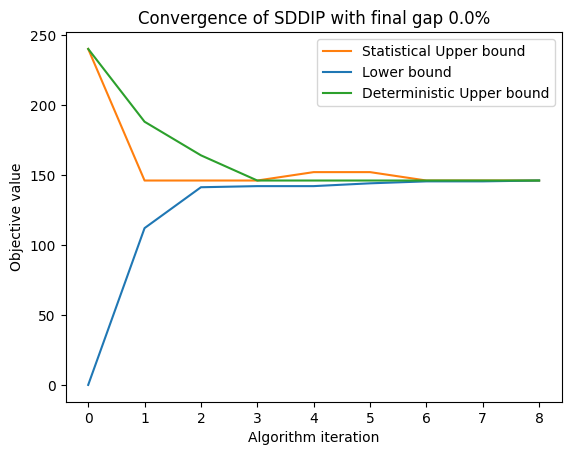

In [2]:
#We define the input path and files
input_path = 'Inputs/ToyGrid/'
instance_file = input_path+'ToyGrid.xlsx'
time_series_file = input_path+'ToyGrid_TS.xlsx'
with open(input_path+'ToyGrid_DRO.pkl', 'rb') as inp:
    dro = pickle.load(inp)
#Other parameters
BiLin_M = 1000 #Parameter for the big M in the linearization of bilinear with x and \psi
bin_exp = {'s':1} #Binary expansion step (s=1 equivalent to an integer formulation)
dro['A_inf'] = 0.5 #Parameter to define the \bar{\beta} parameter [0.3,0.7]
dro['cut_types'] = ['SB','I'] #Which cuts to use. Currently SB (strenghtened benders) and I (integer optimality) cuts
dro['uB_M'] = 160 #BigM for the upper bounding procedure
dro['z_type'] = 'M' #We can choose multi-stage 'M'
T = len(dro['scenario_tree']) #Planning horizon
epsilon = 0.001 #Optimality gap stoppping criterion
total_master_iterations = 30 
relax_mode = False #True if we allow to an initial continuous representation of the state variables
max_seconds = 1800 #maximum runtime for algorithm
M = 1 #Number of samples per iteration


#### Running the SND algorithm ####
scenario_tree,node_tree,global_data,nm_data,a_init,z_init,P_gen_init_bin,P_gen_init_cont,P_limit_init,full_data = initialize_SND(instance_file,time_series_file,bin_exp,dro,T)
start = time.time()
over_time = False
optimized = False 
over_iters = False
iter_report_count = 0
relaxed_gap_limit = 3 #We give a 5 percent budget for the relaxed iterations to improve or we turn to the hard version
relaxed_count = 0
iteration_counter = 1
total_convergence_limit = total_master_iterations*0.05 #WE give a 5 percent budget for the statistical upper bound to converge to the proven optimal

while not optimized and not over_iters and not over_time:
    samples,n_list = sample_T(M,T,scenario_tree) #Sampling the scenario tree
    if relax_mode == True:
        while True: #we keep working with relaxed iterations until we see no further improvement
            forward_pass(M,T,scenario_tree,instance_file,time_series_file,None,dro,a_init,z_init,P_gen_init_cont,P_limit_init,node_tree,nm_data,global_data,iteration_counter,samples,BiLin_M)
            backward_pass(scenario_tree,node_tree,nm_data,None,dro,n_list,T,instance_file,time_series_file,a_init,P_limit_init,P_gen_init_cont,z_init,global_data,iteration_counter,BiLin_M)
            if np.round(list(global_data['Lower bound'].values())[-1],10) == np.round(list(global_data['Lower bound'].values())[-2],10): #no improvement, we increase counter
                relaxed_count += 1
            else:
                # print(f'We had improvement between {np.round(list(global_data["Lower bound"].values())[-1],10)} and {np.round(list(global_data["Lower bound"].values())[-2],10)}')
                relaxed_count = 0
            samples,n_list = sample_T(M,T,scenario_tree) #Sampling the scenario tree
            iteration_counter += 1
            if relaxed_count >= relaxed_gap_limit:
                print(f'No further improvement from continuous relaxation after {iteration_counter} iters. Binarizing continuous variables')
                relax_mode = False
                break
    else:
        forward_pass(M,T,scenario_tree,instance_file,time_series_file,bin_exp,dro,a_init,z_init,P_gen_init_bin,P_limit_init,node_tree,nm_data,global_data,iteration_counter,samples,BiLin_M)
        # print('forward done')
        backward_pass(scenario_tree,node_tree,nm_data,bin_exp,dro,n_list,T,instance_file,time_series_file,a_init,P_limit_init,P_gen_init_bin,z_init,global_data,iteration_counter,BiLin_M)
        # print('Backward done')
        # 
        # print('-------------')
        ub = list(global_data['Strict UB'].values())[-1]
        lb = list(global_data['Lower bound'].values())[-1]
        opt_gap = (ub-lb)/ub
        if opt_gap <= epsilon: #We have proven epsilon-optimality
            print(f'We achieve optimality in {iteration_counter} iterations. Gap {np.round(opt_gap,4)}')
            optimized = True
            break
        if iter_report_count == 1:
            print(f'At iteration {iteration_counter}, gap of {np.round(opt_gap,4)}')
            iter_report_count = 0
        iter_report_count += 1
        iteration_counter += 1
        
        if iteration_counter >= total_master_iterations:
            print(f'We reached the maximum number of iterations with gap {np.round(opt_gap,4)}')
            break
    lb = list(global_data['Lower bound'].values())
    ub = list(np.array(list(global_data['Strict UB'].values())))
    s_ub = np.array(list(global_data['Statistical Upper bound'].values()))
    opt_gap = (ub[-1]-lb[-1])/ub[-1]
    plt.plot(s_ub,label='Statistical Upper bound',color='orange')
    plt.plot(lb,color='blue')
    plt.plot(ub,color='green')

    # plt.legend()
    plt.title(f'Convergence of SDDIP with current gap {np.round(opt_gap*100,2)}%')
    plt.ylabel('Objective value')
    plt.xlabel('Algorithm iteration')
    plt.pause(1)  # pause a bit so that plots are xupdated
    if is_ipython:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    if time.time()-start >= max_seconds:
        print('Max time limit')
        over_time = True
plt.ioff()
lb = list(global_data['Lower bound'].values())
ub = list(np.array(list(global_data['Strict UB'].values())))
s_ub = np.array(list(global_data['Statistical Upper bound'].values()))
plt.plot(s_ub,label='Statistical Upper bound',color='tab:orange')
plt.plot(lb,label='Lower bound',color='tab:blue')
plt.plot(ub,label='Deterministic Upper bound',color='tab:green')

plt.legend()    
plt.title(f'Convergence of SDDIP with final gap {np.round(opt_gap*100,2)}%')
plt.ylabel('Objective value')
plt.xlabel('Algorithm iteration')
plt.show()

In [5]:
#Accessing the genereated scenario tree with the best solutions up to the last iteration
global_data['Current_best']['Best_tree']

{None: {'cuts': {'RSP': {'L_I': {}, 'L_C': {}},
   'SB': {'B': {}, 'C': {}},
   'I': {}},
  'vertices': {}},
 0: {'cuts': {'RSP': {'L_I': {}, 'L_C': {}},
   'SB': {'B': {1: {0: {'pi': array([0., 0., 0., 0., 0., 0.]),
       'gamma': array([0.]),
       'delta': array([0., 0.]),
       'L': 0},
      1: {'pi': [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0],
       'L': 70.0,
       'gamma': [-0.0],
       'delta': [-0.0, -0.0]},
      2: {'pi': [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0],
       'L': 70.0,
       'gamma': [-0.0],
       'delta': [-0.0, -0.0]},
      3: {'pi': [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0],
       'L': 70.0,
       'gamma': [-0.0],
       'delta': [-0.0, -0.0]},
      4: {'pi': [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0],
       'L': 70.0,
       'gamma': [-0.0],
       'delta': [-0.0, -0.0]},
      5: {'pi': [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0],
       'L': 94.0,
       'gamma': [-0.0],
       'delta': [-0.0, -0.0]},
      6: {'pi': [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0],
       'L': 94.0